# Exploratory Data Analysis (EDA) on the Bank Account Fraud (BAF) dataset

This Jupyter notebook performs Exploratory Data Analysis (EDA) on one of the six synthetic tabular datasets in the Bank Account Fraud (BAF) suite of datasets. The BAF datasets were published at NeurIPS 2022 and are intended to provide a realistic, complete, and robust test bed to evaluate novel and existing methods in machine learning (ML) and fair ML.

## Dataset Information
The BAF suite of datasets comprises a total of 6 different synthetic bank account fraud tabular datasets. The datasets are realistic, based on a present-day real-world dataset for fraud detection, and each dataset has distinct controlled types of bias. Additionally, the datasets have an imbalanced setting with an extremely low prevalence of positive class, contain temporal data and observed distribution shifts, and have privacy-preserving features to protect the identity of potential applicants.

In this notebook, we will be exploring one of the datasets in the BAF suite, the Base.csv dataset.

## Loading and describing the dataset
We start by loading the dataset into a Pandas DataFrame and displaying its first few rows using the head() function. We then display some basic statistics of the dataset using the describe() function.

In [4]:
import pandas as pd

# Read in the data
df = pd.read_csv('../dataset/Base.csv', header=0)
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [5]:
df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,...,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,...,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,...,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,...,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,...,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,...,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


## Boxplot
We then use the Seaborn library to create boxplots of the numerical columns in the dataset. Boxplots are used to visualize the distribution and outliers of each numerical column.

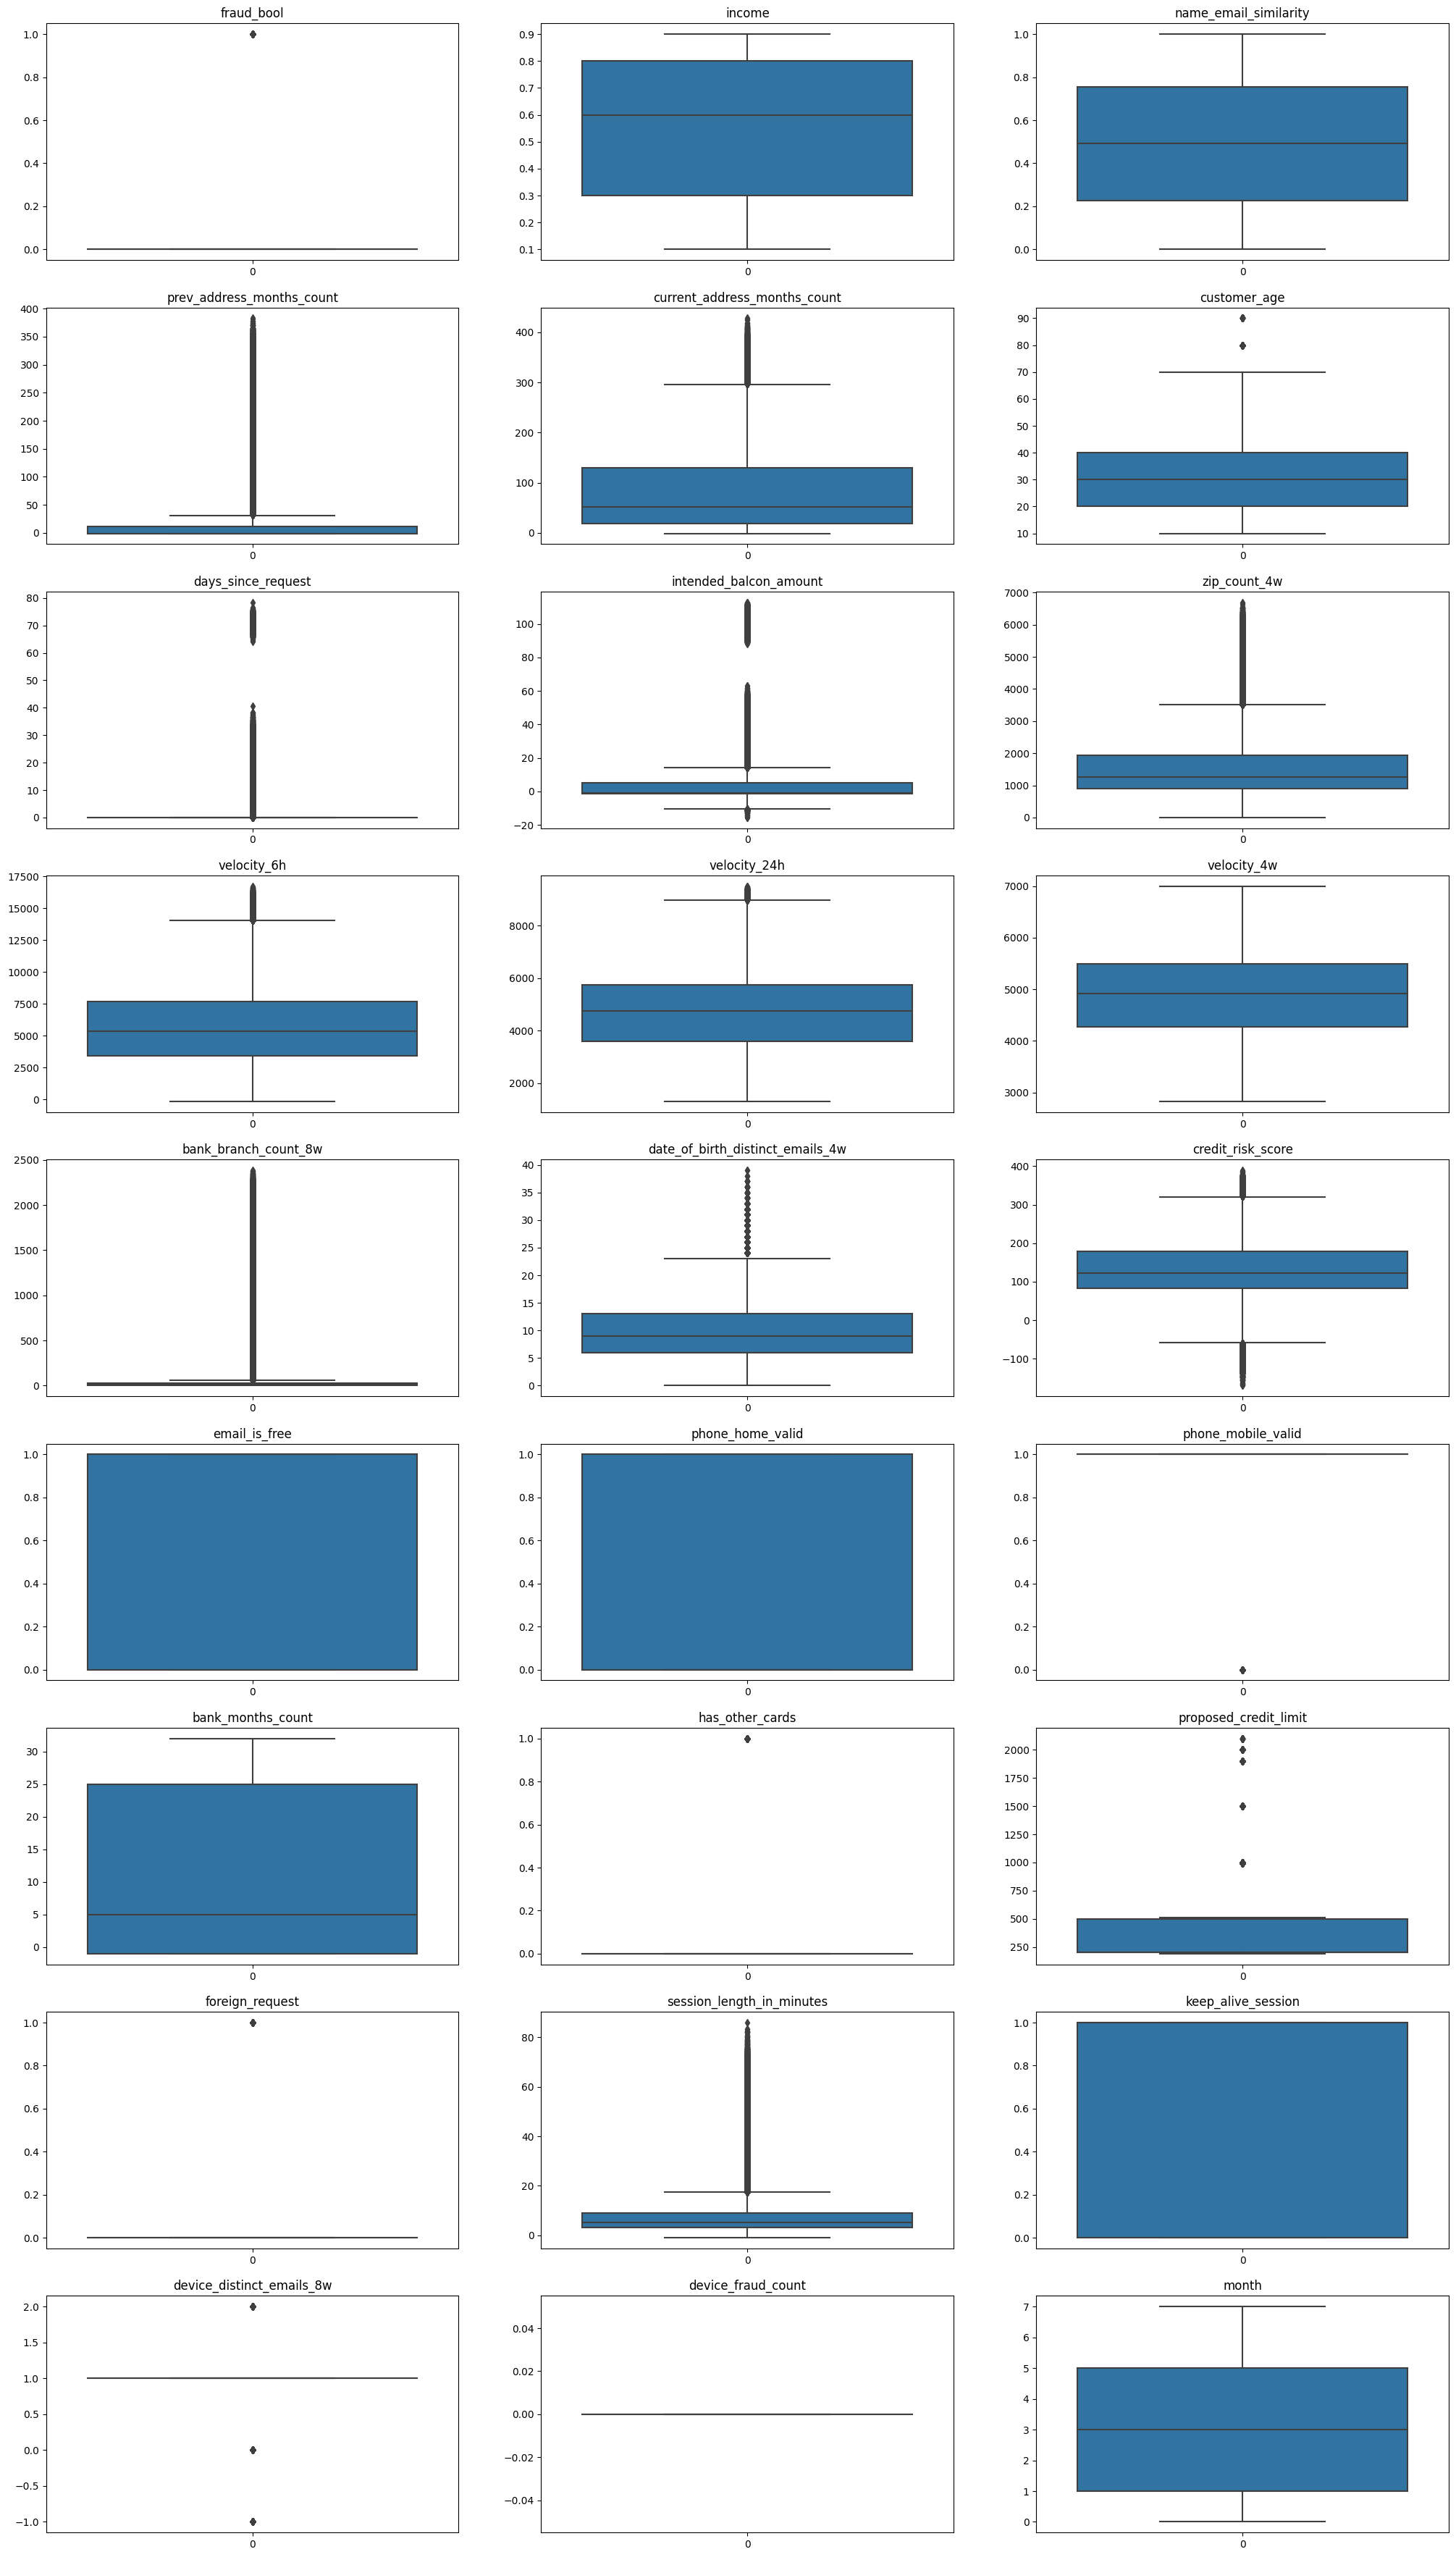

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# get the list of numerical columns
num_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()

# create a grid of subplots using seaborn
n_cols = 3  # number of columns in the grid
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # number of rows in the grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 5*n_rows))

# loop through the columns and create a boxplot for each one
for i, col in enumerate(num_cols):
    row_idx = i // n_cols  # row index for this subplot
    col_idx = i % n_cols  # column index for this subplot
    ax = sns.boxplot(data=df[col], ax=axes[row_idx, col_idx])
    ax.set_title(col)

## Analyzing Outliers
Outliers can take many different forms in a dataset. In some cases, outliers may be extreme values that fall far outside the expected range of the data, while in other cases, outliers may appear as discontinuities or gaps in the data. In this particular dataset, it has been observed that there are some columns - customer_age, days_since_request, intended_balcon_amount, and proposed_credit_limit - that contain discontinuous points. These points may represent missing data or errors in data collection, or they may be indicative of some other pattern in the data. In the next section, we will explore these columns in more detail and investigate the potential causes and implications of these discontinuous points.

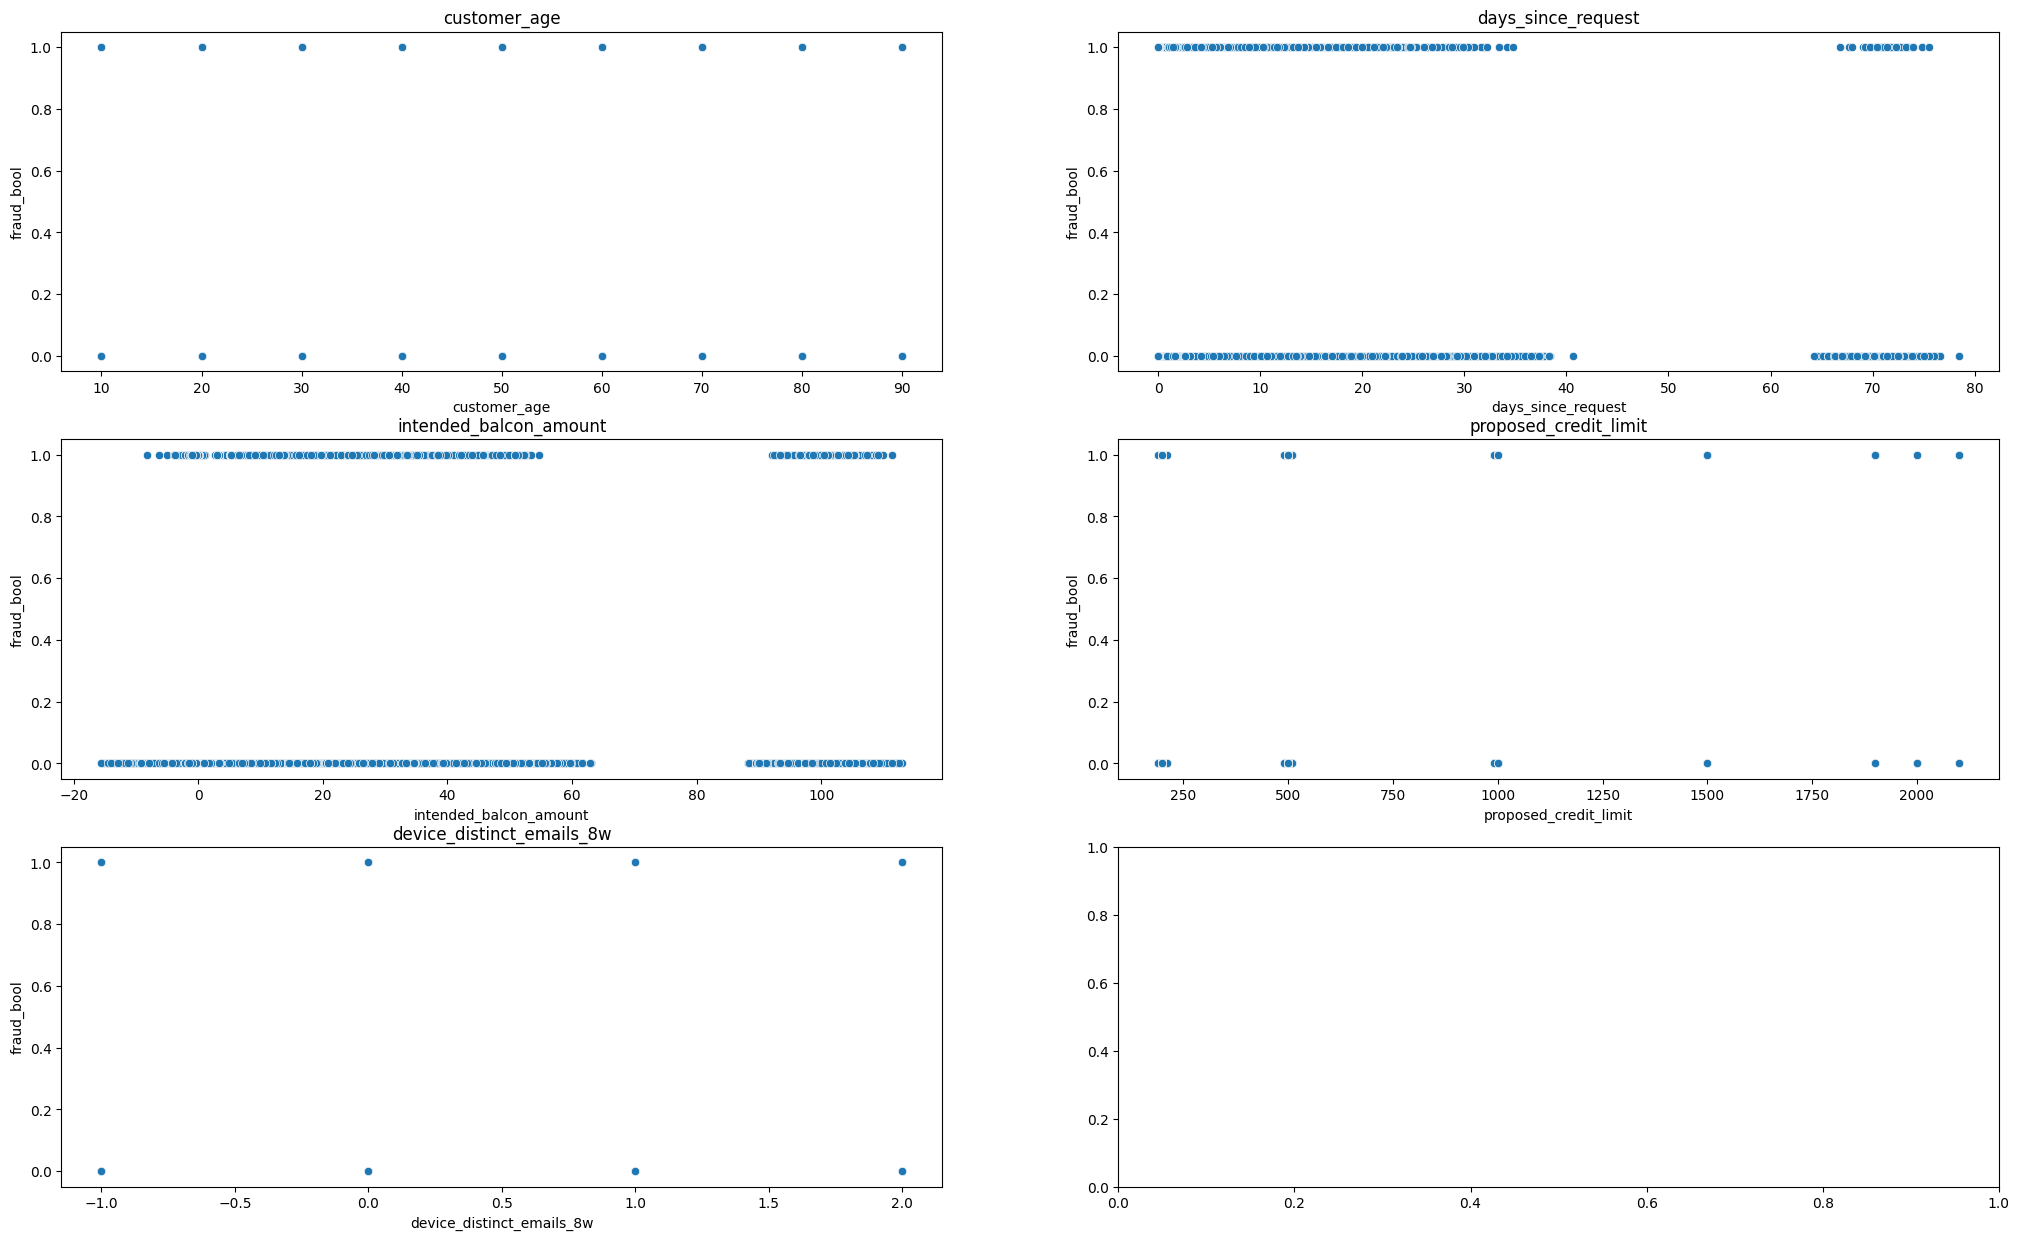

In [4]:
label_column = 'fraud_bool'
columns_to_analyze = ['customer_age', 'days_since_request', 'intended_balcon_amount', 'proposed_credit_limit', 'device_distinct_emails_8w']

# create a grid of subplots using seaborn
n_cols = 2  # number of columns in the grid
n_rows = (len(columns_to_analyze) + n_cols - 1) // n_cols  # number of rows in the grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 5*n_rows))

# loop through the columns and create a boxplot for each one
for i, col in enumerate(columns_to_analyze):
    row_idx = i // n_cols  # row index for this subplot
    col_idx = i % n_cols  # column index for this subplot
    ax = sns.scatterplot(x=col, y=label_column, data=df, ax=axes[row_idx, col_idx])
    ax.set_title(col)

Based on our analysis, it appears that there are no significant differences in the values of the variables investigated between the fraud and non-fraud categories. This suggests that outliers in these variables are not particularly informative or indicative of fraud, and may simply be due to random variations or noise in the data.

Given this result, it may not be necessary to remove outliers from these variables in order to improve the accuracy of your analysis or model.

In [5]:
# Determine the upper and lower bounds for outliers
#num_cols = df.select_dtypes(include=['float']).columns.tolist()


# loop through the columns and remove the outliers
#for i, col in enumerate(num_cols):
#    Q1 = df[col].quantile(0.25)
#    Q3 = df[col].quantile(0.75)
#    IQR = Q3 - Q1
#    lower_bound = Q1 - (1.5 * IQR)
#    upper_bound = Q3 + (1.5 * IQR)
#    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [6]:
#df.describe()

In [7]:
#import seaborn as sns
#import matplotlib.pyplot as plt
#import os

# get the list of numerical columns
#num_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()

# create a grid of subplots using seaborn
#n_cols = 3  # number of columns in the grid
#n_rows = (len(num_cols) + n_cols - 1) // n_cols  # number of rows in the grid
#fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 5*n_rows))

# loop through the columns and create a boxplot for each one
#for i, col in enumerate(num_cols):
#    row_idx = i // n_cols  # row index for this subplot
#    col_idx = i % n_cols  # column index for this subplot
#    ax = sns.boxplot(data=df[col], ax=axes[row_idx, col_idx])
#    ax.set_title(col)

## Correlation Matrix
We can calculate the correlation matrix between the numerical features in the dataset to see how they are related to each other. This can give us some insight into which features are most important for predicting fraud.

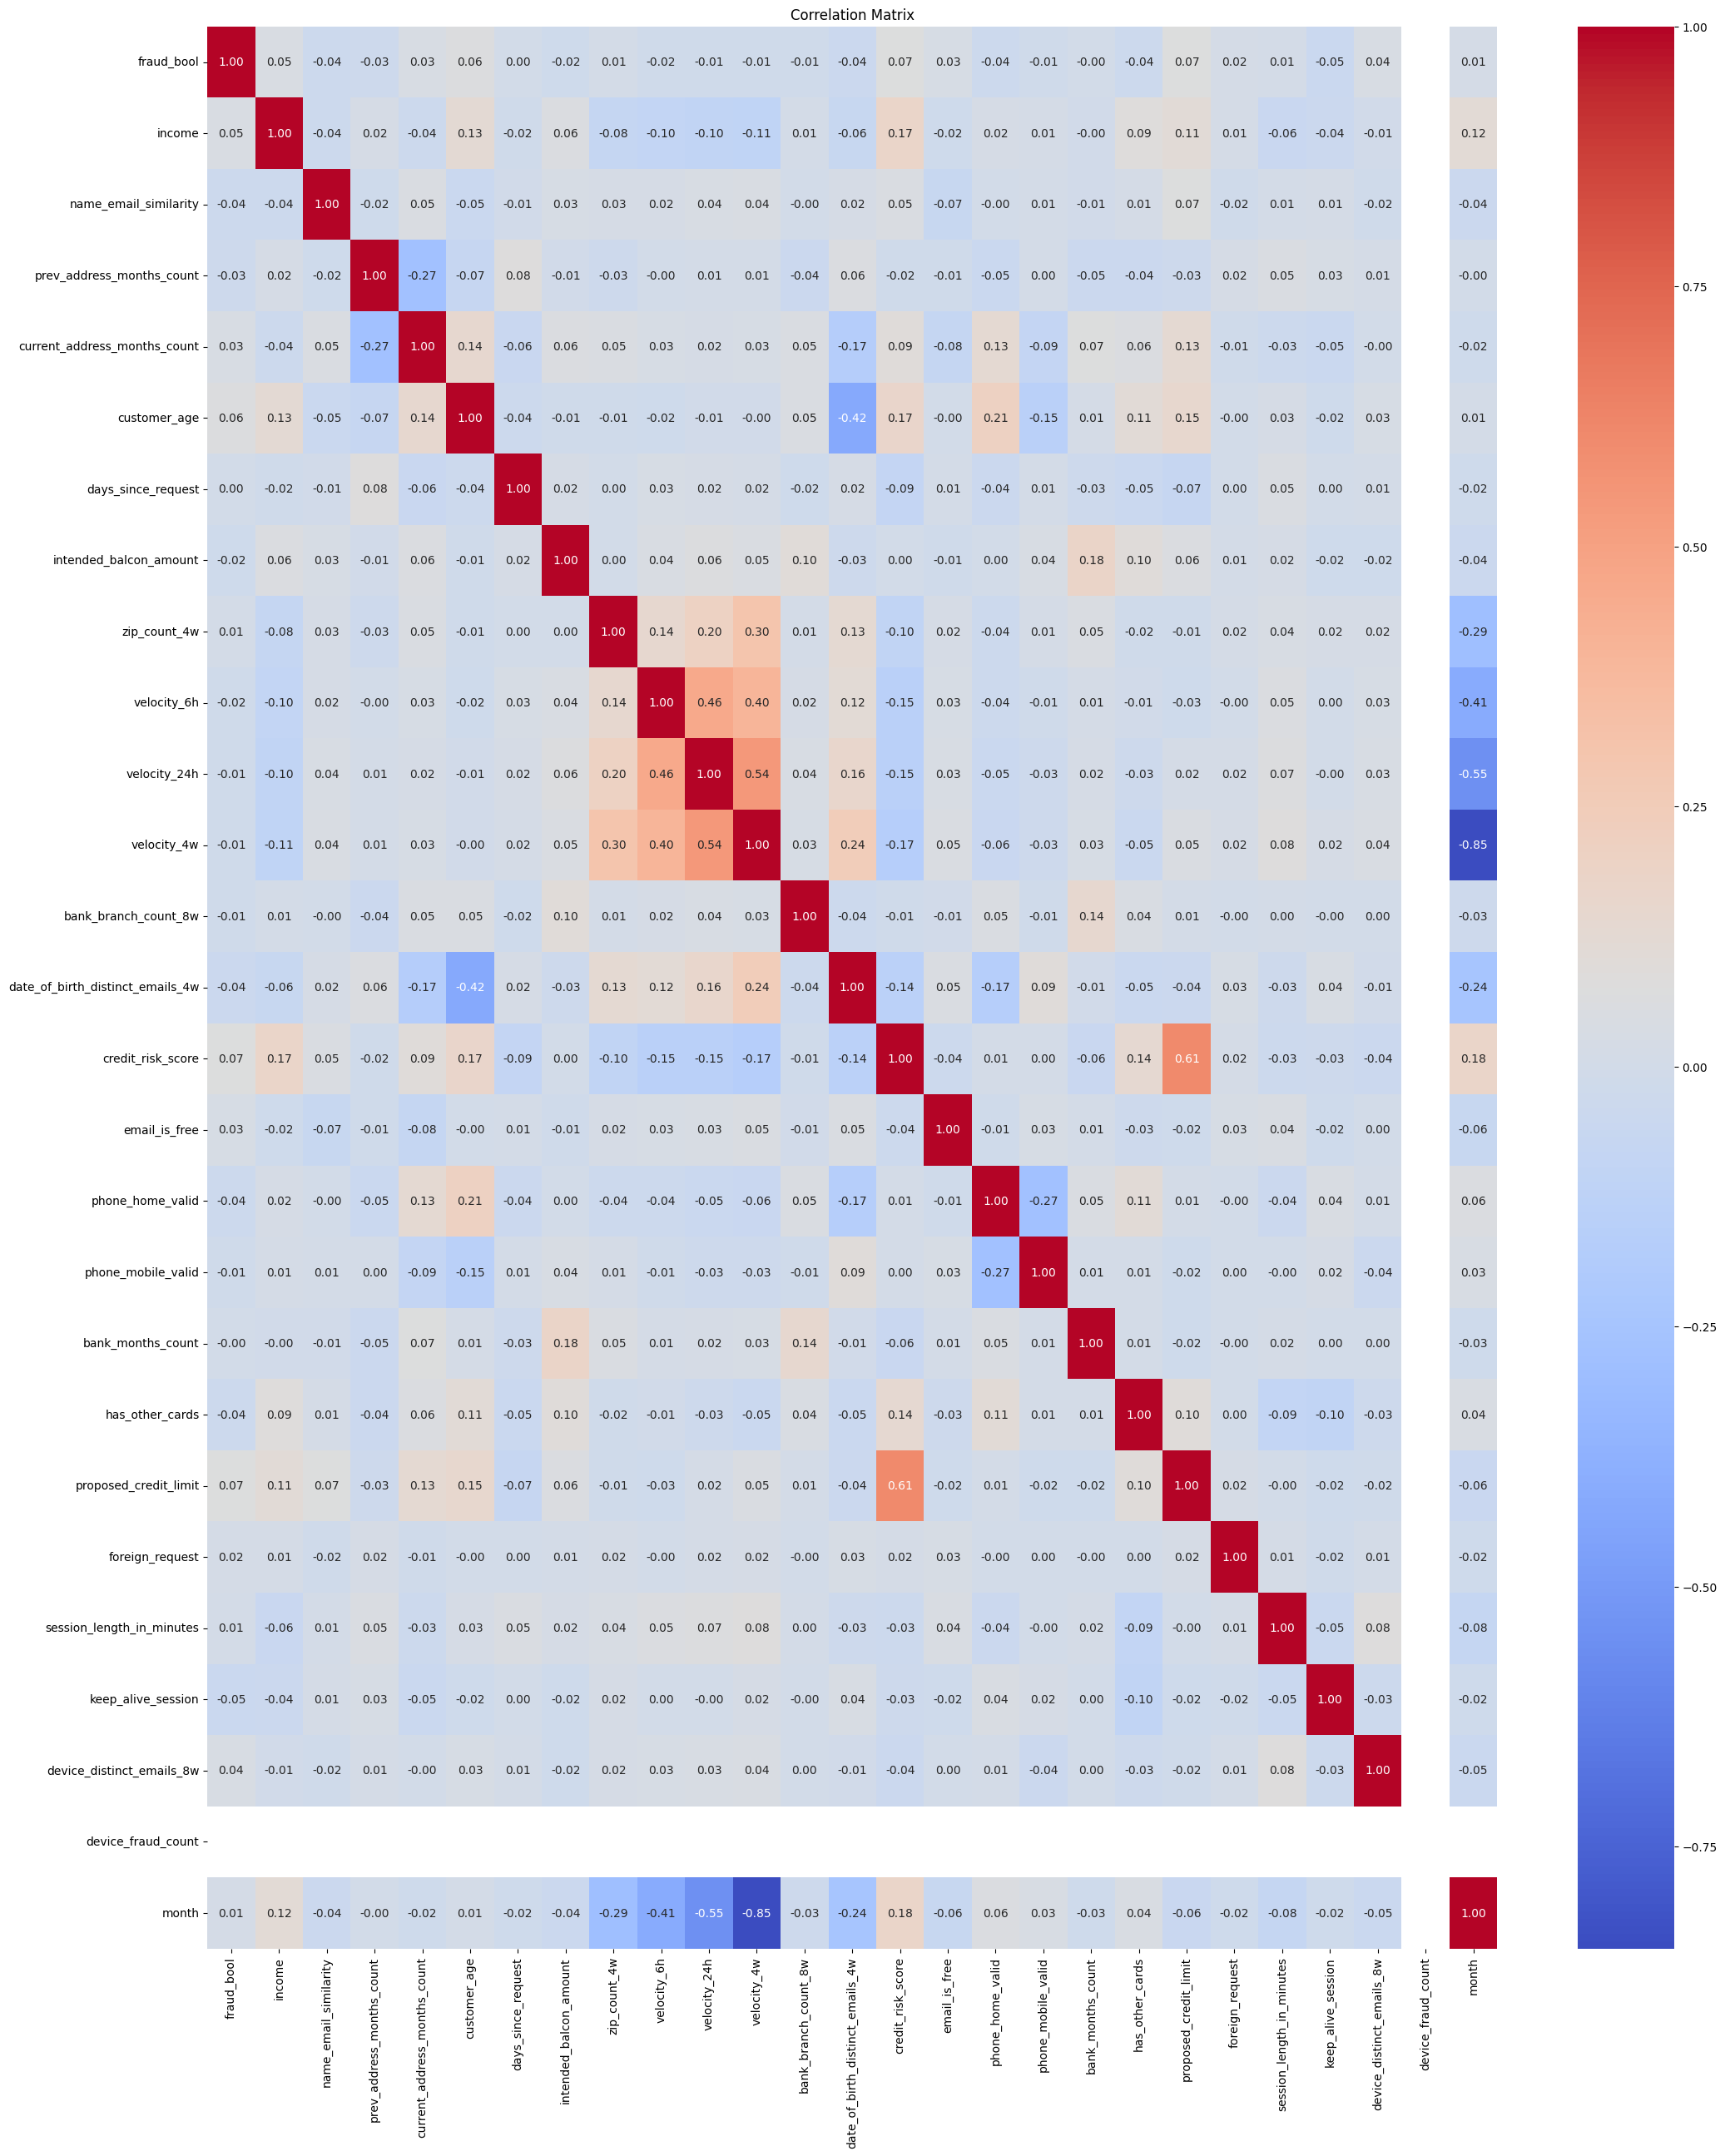

In [8]:
# Calculate the correlation matrix
corr_matrix = df.select_dtypes(include=['float', 'int']).corr()

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(25, 30))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})
plt.title('Correlation Matrix')
plt.show()

## Histograms
We can also create histograms of the numerical columns to see the distribution of each feature. This can help us identify any features that may need to be transformed to achieve a normal distribution.

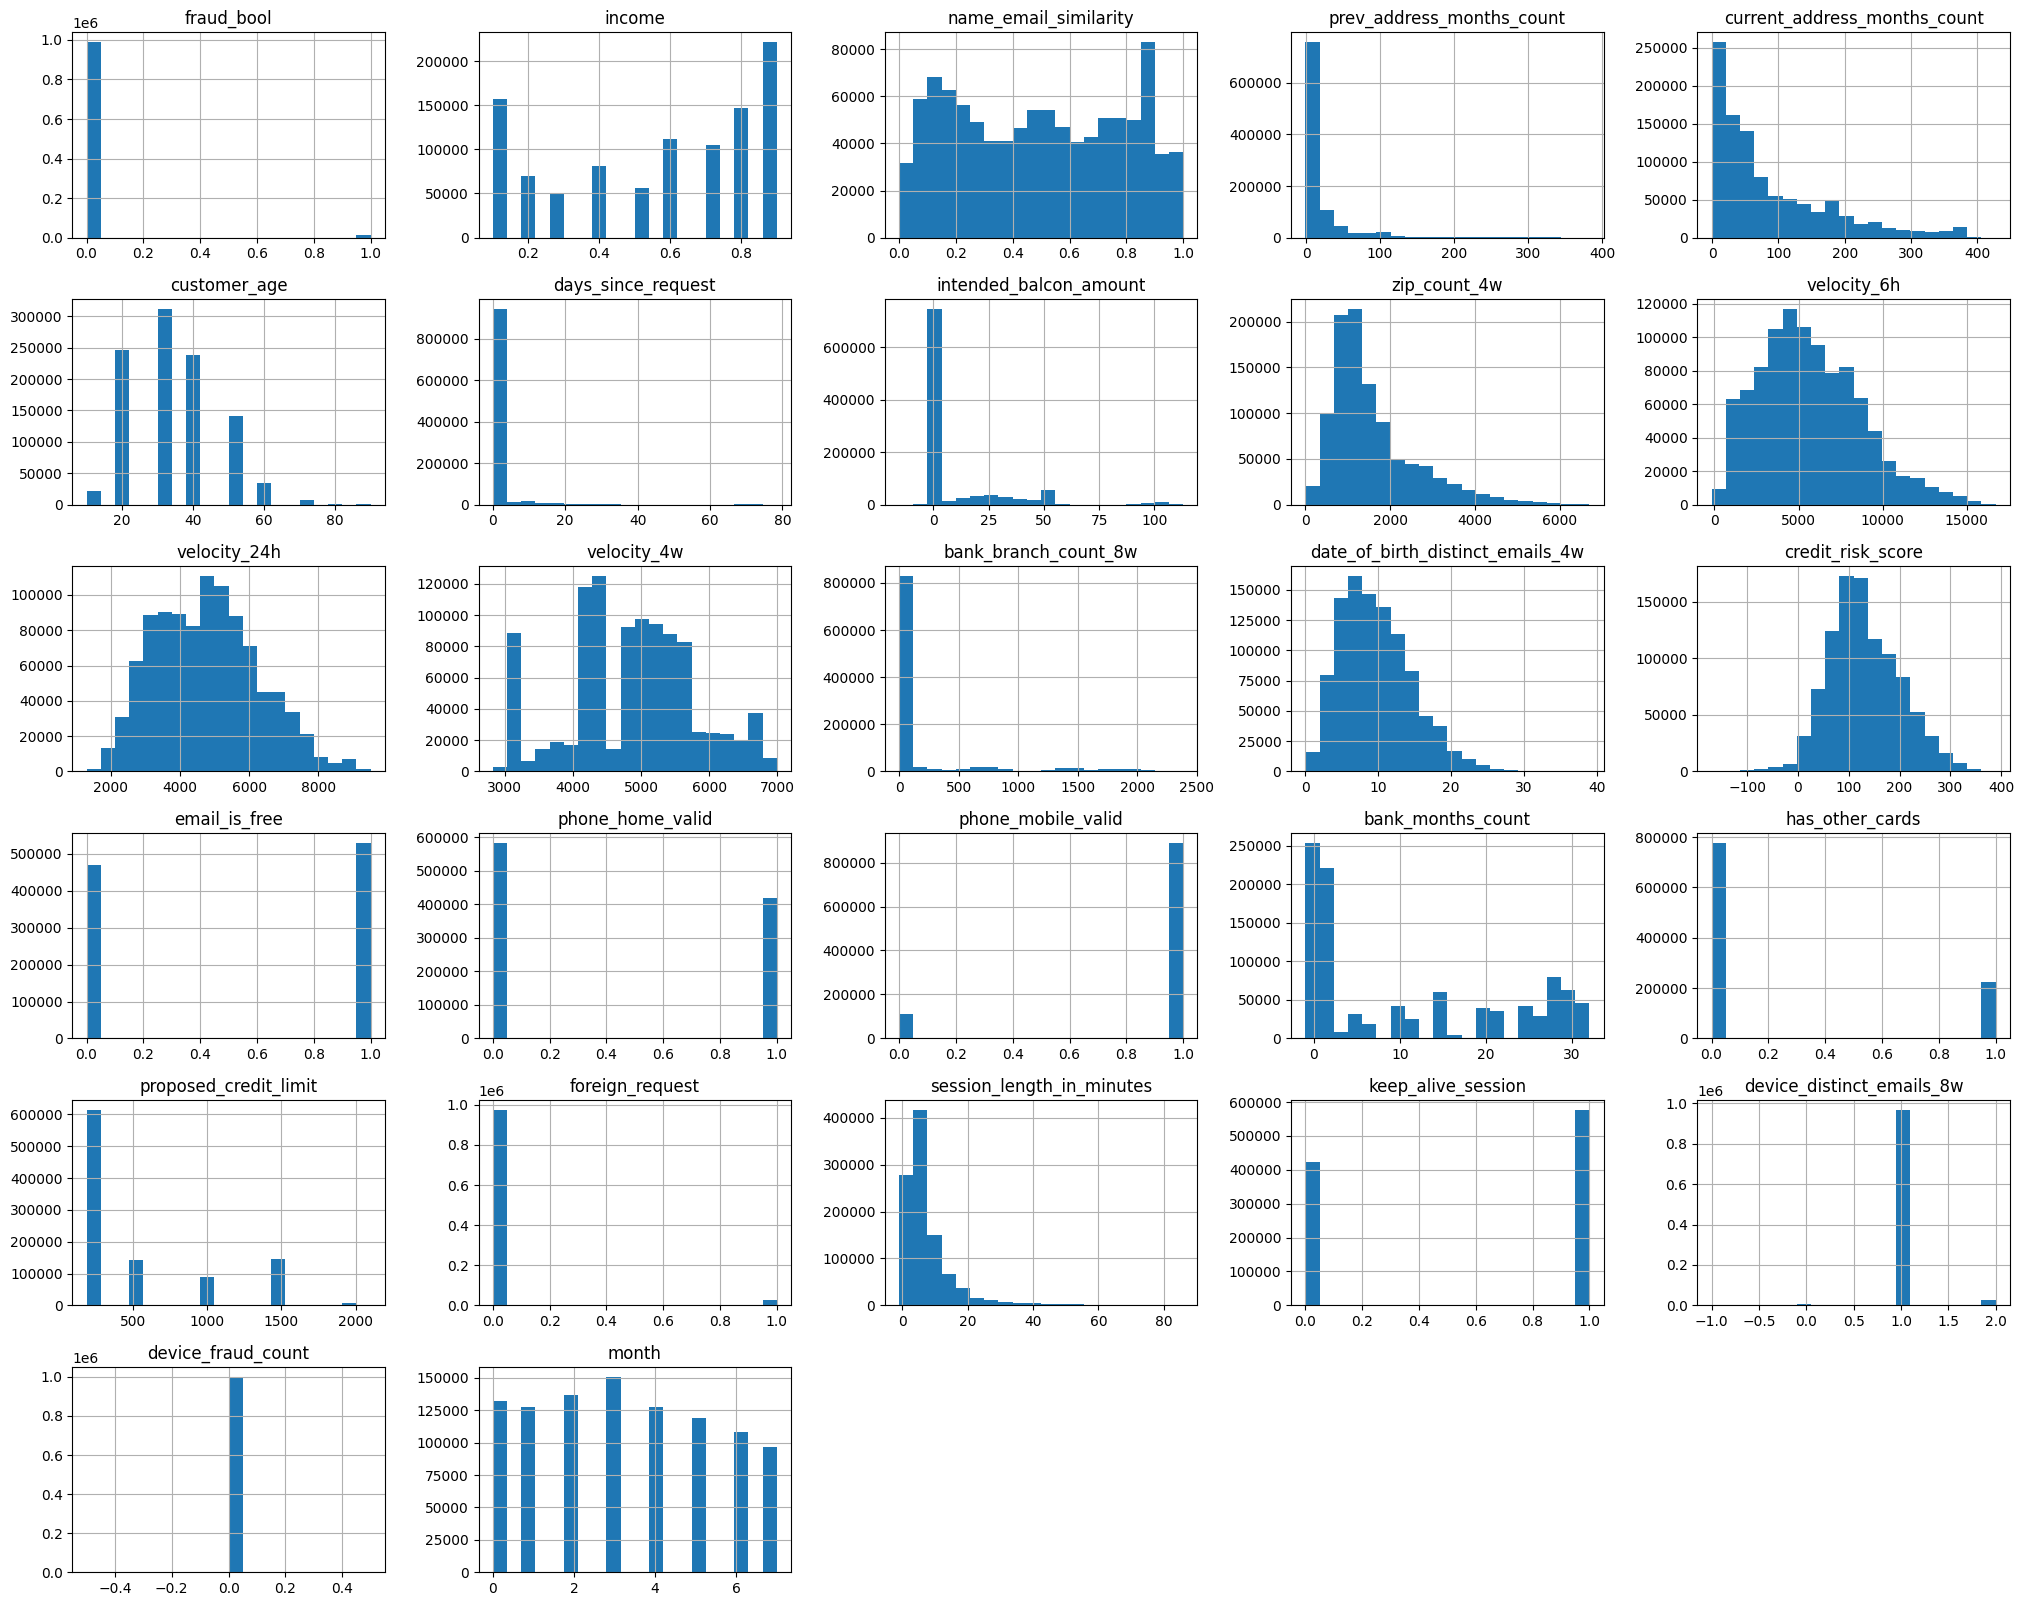

In [9]:
# Create histograms of the numerical columns
df.hist(bins=20, figsize=(25, 20))
plt.show()

## Count Plot
Finally, we can create a count plot to visualize the distribution of the target variable (fraud). This can help us identify the class imbalance in the dataset.

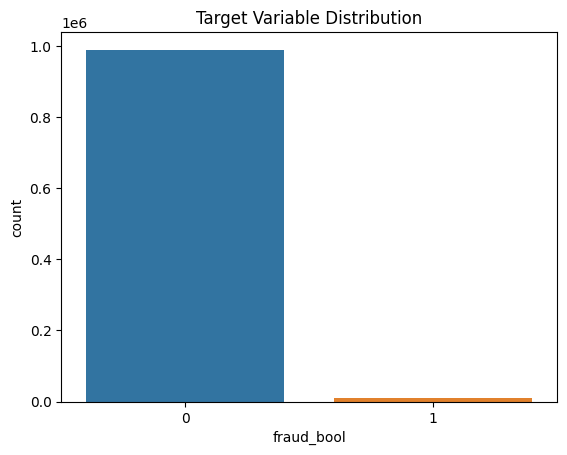

fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64

In [9]:
# Create a count plot of the target variable
sns.countplot(x='fraud_bool', data=df)
plt.title('Target Variable Distribution')
plt.show()


df['fraud_bool'].value_counts(normalize=True)



The previous plot shows that the dataset is highly imbalanced, with only 0.01% of the data belonging to the fraud class. This can pose challenges in building models that accurately predict fraud, as the model may be biased towards predicting non-fraud cases.
To address this issue, we have various techniques to deal with imbalanced datasets, such as oversampling, undersampling.

In [12]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X = df.drop('fraud_bool', axis=1)
Y = df['fraud_bool']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, y_train = shuffle(X_train, Y_train, random_state=1)

# Perform SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Perform random undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, Y_train_resampled = rus.fit_resample(X_train, Y_train)

# Train a Random Forest classifier on the balanced data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, Y_train_resampled)

ValueError: could not convert string to float: 'AA'

## Creating a smaller dataset


In [11]:
training_data = df.sample(frac=0.1, random_state=1)
df.sample
training_data.shape

(100000, 32)

## Data Encoding
In order to encode some of our variables, we looked up some of the most used encoding methods. We ended up choosing Ordinal Encoding for High-Cardinality Variables because we have categorical variables with a high number of unique values (high-cardinality). Being that using one-hot encoding might lead to a large number of resulting columns and given that we want to reduce the number of columns, One-Hot Encoding turns out not being the best choice. So we decided to use ordinal encoding, which assigns unique integers to each category.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

dataset = df.copy()

columns_to_encode = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

encoder = OrdinalEncoder()

dataset[columns_to_encode] = encoder.fit_transform(dataset[columns_to_encode])

#print(dataset)

X = dataset.drop('fraud_bool', axis=1) #Features 
y = dataset['fraud_bool'] # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Naive Bayes
Naive Bayes is a classification algorithm based on Bayes' theorem. It assumes that features are independent and calculates the probability of an instance belonging to a class. It's computationally efficient, works well with high-dimensional data, and performs best when the independence assumption holds.

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Instantiate and train the Naive Bayes classifier
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.94474


## Decision Tree
Decision Trees are classification algorithms that create a tree-like model of decisions. Each internal node represents a feature, and each leaf node represents a class label. They split the data based on feature values to create homogeneous subsets. When making predictions, a new instance traverses the tree to a leaf node, and the corresponding class label is assigned. Decision Trees are interpretable and handle categorical and numerical data, capturing complex decision boundaries.

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.97784


## k-Nearest Neighbours (KNN) 
k-Nearest Neighbors (KNN) is a classification algorithm that predicts the class of an instance based on its k nearest neighbors in the feature space. It assumes that instances with similar features tend to belong to the same class. During training, KNN stores the feature vectors and their corresponding class labels. When making predictions, it finds the k nearest neighbors to the target instance and assigns the majority class among those neighbors as the predicted class. KNN is a simple and versatile algorithm that can handle both linear and non-linear classification tasks, making it useful in various applications.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.98906


## Logistic Regression
Logistic Regression is a classification algorithm that predicts the probability of an instance belonging to a specific class. It uses a sigmoid function to map input features to a binary output. By fitting a decision boundary during training, Logistic Regression separates the classes. When making predictions, it calculates the probability of an instance belonging to the positive class and applies a threshold for classification. Logistic Regression is a simple and effective algorithm suitable for binary classification tasks, handling linearly and non-linearly separable data with appropriate transformations or kernel functions.

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.98918


C:\Users\ricar\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Support Vectors (SVM)
Support Vector Machines (SVM) are powerful classifiers that can handle both linear and non-linear classification tasks. They work by finding an optimal hyperplane that maximally separates the data points of different classes. SVMs also offer various kernels (e.g., linear, polynomial, radial basis function) to capture complex relationships between the features.

In [16]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

## Random Forest 
Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. Each decision tree is trained on a random subset of the data, and the final prediction is determined by aggregating the predictions of individual trees. Random Forests are effective in handling complex datasets, capturing non-linear relationships, and mitigating overfitting.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9892
